In [2]:
import os

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"

import sys

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

In [3]:
test = MerfishDataset("../data")

In [48]:
import torch

responses = None
for i in range(len(test)):
    if responses is None:
        responses = test[i].x[:, test.responses]
    else:
        responses = torch.cat((responses, test[i].x[:,test.responses]), axis=0)

In [49]:
responses.shape

torch.Size([854339, 84])

In [29]:
import matplotlib.pyplot as plt

KeyboardInterrupt: 

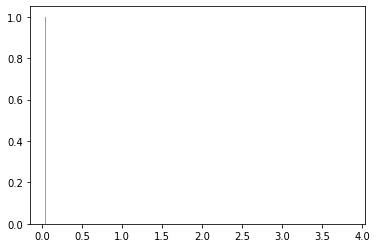

In [50]:
for i in range(responses.shape[1]):
    plt.hist(responses[:, i], bins=10)

In [ ]:
plt.hist(responses[:, i], bins=10)

In [37]:
test[0].x[test.responses][:,0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2676,
        0.0000, 0.0000, 0.0000, 0.9632, 0.0000, 0.0000, 0.9512, 0.5353, 0.0000,
        0.0000, 0.0000, 0.0000, 1.1852, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7983, 0.8683, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4670, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2989, 0.0000, 0.6853, 3.2824, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.4565, 0.7182, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])

(array([75.,  7.,  0.,  1.,  1.]),
 array([0.        , 0.65648746, 1.3129749 , 1.9694624 , 2.6259499 ,
        3.2824373 ], dtype=float32),
 <BarContainer object of 5 artists>)

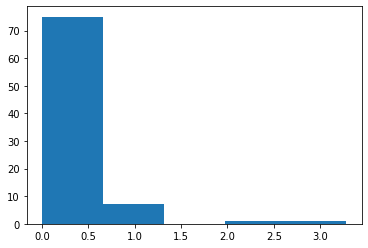

In [39]:
import numpy as np
plt.hist(np.array(test[0].x[test.responses][:,0]), bins=5)